# 線形判別分析(LDA:linear discriminant analysis)

計算効率を高め、正則化されていないモデルで「次元の呪い」による過学習を抑制するために利用できる。  
PCAがデータセットにおいて分散が最も大き直行成分軸を見つけ出そうとするのに対し、LDAはクラスの分離可能性を最適化する特徴量部分空間を見つけ出そうとする。

LDAはデータが正規分布に従っているという仮定をおく。また、クラスの共分散行列がまったく同じで、訓練データが統計的に見て互いに独立しているという仮定もおく。

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

# データセット読み込み
wine = load_wine()

# 特徴量をデータフレームに変換
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)

# クラスラベルを追加
df_wine['target'] = wine.target

# 確認
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values
# データセットをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
print(y_train[:10])

[2 0 0 0 2 1 1 2 1 1]


In [4]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(3):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f"Class: {label}, Mean vector: {mean_vecs[-1]}")
    

Class: 0, Mean vector: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]
Class: 1, Mean vector: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]
Class: 2, Mean vector: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


* クラス内変動行列の計算

In [5]:
d = len(mean_vecs[0])
S_W = np.zeros((d, d))
for label, mv in zip(range(3), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T, bias=True)
    S_W += class_scatter

print(f"Within-class scatter matrix:", f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


* クラス間変動行列の計算

In [6]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print(f"Between-class scatter matrix:", f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


* 線形判別を選択  
$S_W^{-1} S_B$の一般化された固有値問題を解く。（これはフィッシャーの判別式を最適化問題とみなしたときに、ラグランジュ未定乗数法を用いると導出できる。）

In [7]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:')
for i in eigen_pairs:
    print(i[0])

Eigenvalues in descending order:
358.00420701336594
177.07768640666234
5.684341886080802e-14
2.6235607936928547e-14
2.6235607936928547e-14
1.8783798036207385e-14
1.8783798036207385e-14
1.3167252810912486e-14
1.3167252810912486e-14
1.170604617065478e-14
7.771497426010382e-15
4.787463330013483e-15
4.787463330013483e-15


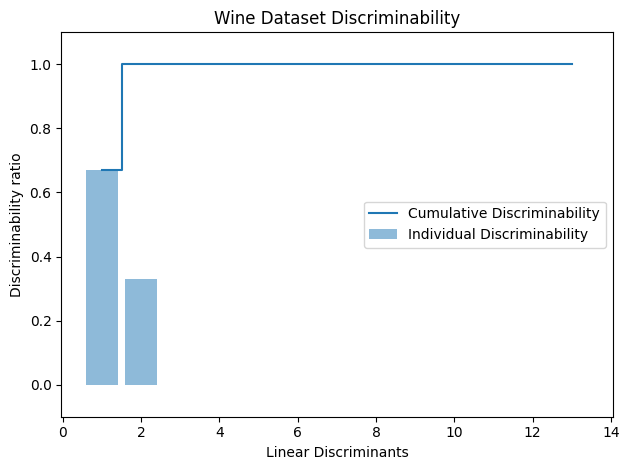

In [8]:
import matplotlib.pyplot as plt
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, len(discr) + 1), discr, alpha=0.5, align='center', label='Individual Discriminability')
plt.step(range(1, len(cum_discr) + 1), cum_discr, where='mid', label='Cumulative Discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.title('Wine Dataset Discriminability')
plt.tight_layout()
plt.show()

In [9]:
# 分散の約60％を捉えることができる
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
                eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1484 -0.4093]
 [ 0.091  -0.1583]
 [-0.0168 -0.3536]
 [ 0.1487  0.322 ]
 [-0.0165 -0.0813]
 [ 0.1912  0.0841]
 [-0.7333  0.2828]
 [-0.0751 -0.0099]
 [ 0.002   0.0902]
 [ 0.2953 -0.2168]
 [-0.0327  0.274 ]
 [-0.3539 -0.0133]
 [-0.3918 -0.5954]]


In [10]:
X_train_lda = X_train_std.dot(w)

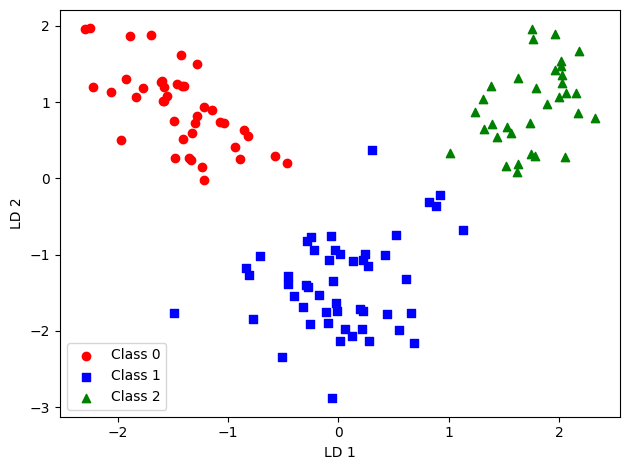

In [11]:
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
# 「クラスラベル」「点の色」「点の種類」の組み合わせからなるリストを生成してプロット
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1]*(-1), # Y軸を反転
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## scikit-learnのLDA

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # マーカーとカラーマップの準備
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    # グリッドポイントの等高線をプロット
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)

    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # クラスごとに訓練データをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=f'Class{cl}',
                    edgecolor='black')
        
    # テストデータ点を目立たせる（点を○で表示）
    if test_idx:
        # すべてのテストデータ点をプロット
        X_test, y_test = X[test_idx], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', alpha=1.0, linewidths=1, marker='o', s=100, label='Test set', edgecolor='black')


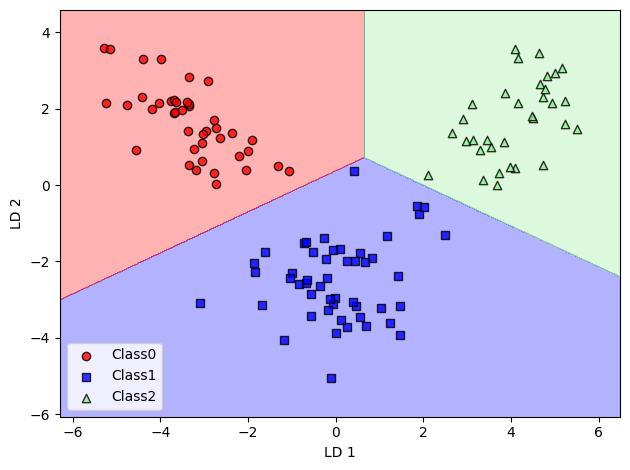

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
# ロジスティック回帰モデルをldaで変換したデータに適用
lr = LogisticRegression(solver='lbfgs', random_state=1)
# 次元削減
X_train_lda = lda.fit_transform(X_train_std, y_train)
# モデルの学習
lr.fit(X_train_lda, y_train)
# 決定境界をプロット
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

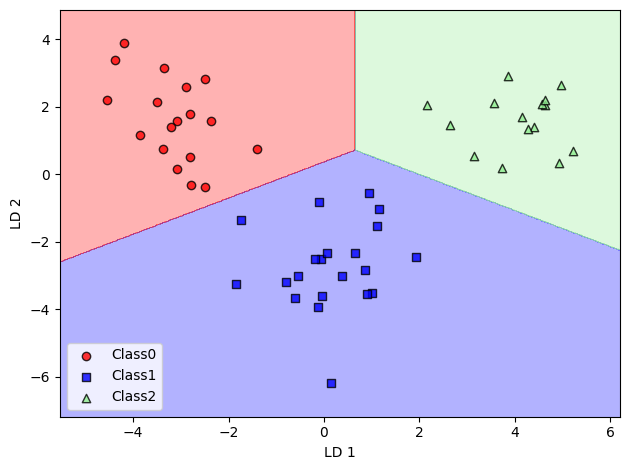

In [14]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()